In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from presentation.pipelines.steps.model_design import build_model
from presentation.pipelines.steps.load_data import build_loader
from src.data.zero import pretraining_pipeline
import os

%load_ext autoreload
%autoreload 2

2024-08-30 12:12:07.320266: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 12:12:07.343447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 12:12:07.343465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 12:12:07.343490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 12:12:07.348788: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 12:12:07.349152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
params = {
    'num_layers':2,
    'head_dim':64,
    'num_heads':4,
    'window_size':200,
    'mixer':128,
    'pe_base':1000,
    'pe_dim':256,
    'pe_exp':2,
    'dropout':0.,
    'use_leak':False,
    'm_alpha':1,
    'loss_format':'rmse',
    'correct_loss':False,
    'temperature':0.,
    'mask_format':'QK',
    'no_msk_token':True
}

zero_params = {**params, **{'arch': 'zero'}}
base_params = {**params, **{'arch': 'base'}}
base_params['pe_base'] = 10000

In [4]:
astromer_0 = build_model(zero_params)
astromer_1 = build_model(base_params)


[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00


2024-08-30 12:12:08.849357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 12:12:08.850073: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: QK


In [5]:
astromer_0.load_weights('presentation/results/alcock_test/2024-08-23_23-37-39/pretraining/weights')
astromer_1.load_weights('presentation/results/alcock_test/2024-08-23_23-37-39/pretraining/weights')

In [28]:
datapath = './data/records/alcock/fold_0/alcock_20'
params = {
    'probed': 1.,
    'rs':0.,
    'same':0.,
    'norm':'zero-mean',
    'window_size': 200,
    'arch':'zero'
}
loaders = build_loader(data_path=datapath,  
                       params=params,
                       shuffle=False, 
                       batch_size=16)

zero_loader = pretraining_pipeline(dataset=os.path.join(datapath, 'train'),
                                   batch_size=16, 
                                   window_size=params['window_size'], 
                                   msk_frac=params['probed'],
                                   rnd_frac=params['rs'], same_frac=params['same'], 
                                   sampling=False,
                                   shuffle=False,
                                   return_ids=True)


[INFO] Changing path:  ./data/records/alcock/fold_0/alcock_20/val
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Zero
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Zero


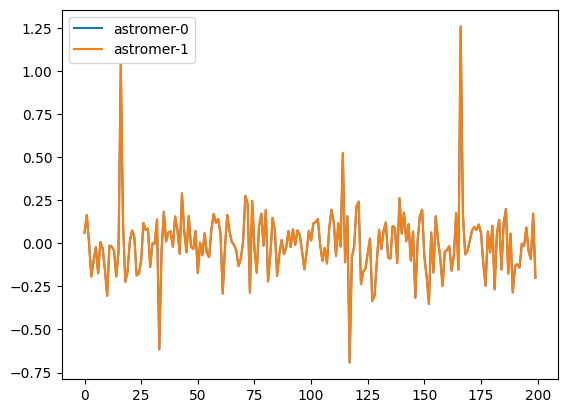

In [31]:
encoder_0 = astromer_0.get_layer('encoder')
encoder_1 = astromer_1.get_layer('encoder')

for batch_0, batch_1 in zip(loaders['train'].take(1), zero_loader.take(1)):
    plt.plot(batch_0[0]['input'][1], label='astromer-0')
    plt.plot(batch_1[0]['input'][1], label='astromer-1')
plt.legend()
    # out_0 = astromer_0(x)
    # out_1 = astromer_1(x)

In [67]:
out_0.shape

TensorShape([16, 200, 1])

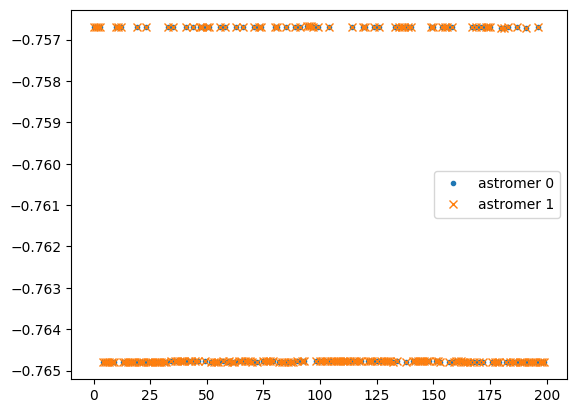

In [71]:
plt.plot(out_0[0], label='astromer 0', marker='.', linestyle='')
plt.plot(out_1[0], label='astromer 1', marker='x', linestyle='')
plt.legend()